In [1]:
import pandas as pd
df = pd.read_csv('./citibike_2023_cleaned.csv')

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score

#split the dataset into features and labels
features = df.drop(columns=['member_casual'])
label = df['member_casual']

encoded = pd.get_dummies(label, columns=['member_casual'], dtype=int)
member = encoded['member']

#split the data into development (80%) and test datasets (20%)
x_dev, x_test, y_dev, y_test = train_test_split(features, member, test_size=0.2)

In [3]:
!pip install category_encoders

   ---------------------------------------- 0.0/82.0 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/82.0 kB ? eta -:--:--
   -------------- ------------------------- 30.7/82.0 kB 660.6 kB/s eta 0:00:01
   ------------------- -------------------- 41.0/82.0 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 82.0/82.0 kB 771.6 kB/s eta 0:00:00


In [18]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import numpy as np

#define which columns will have which transformations
oh_features = ['rideable_type']
ord_features = ['start_station_name', 'end_station_name']

#define transformations
one_h = OneHotEncoder(handle_unknown='ignore')
ord_e = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

preprocess = ColumnTransformer(transformers = [('onehot', one_h, oh_features),
                                               ('ordinal', ord_e, ord_features)], remainder = 'passthrough')
pipeline = Pipeline(steps=[('prep',preprocess)])

#apply encoding
x_dev_enc = pipeline.fit_transform(x_dev)
x_test_enc = pipeline.transform(x_test)

onehot_features = pipeline.named_steps['prep'].transformers_[0][1].get_feature_names_out(oh_features)
# Combine feature names
all_features = np.concatenate([onehot_features, x_dev.drop(columns=oh_features + ord_features).columns, ord_features])

# Create DataFrames
x_dev_encoded = pd.DataFrame(x_dev_enc, columns=all_features, index=x_dev.index)
x_test_encoded = pd.DataFrame(x_test_enc, columns=all_features, index=x_test.index)

In [19]:
x_dev_encoded.corr()

,rideable_type_classic_bike,rideable_type_docked_bike,rideable_type_electric_bike,start_lat,start_lng,end_lat,end_lng,month,day,start_hour,start_minute,end_hour,end_minute,trip_duration,start_station_name,end_station_name
rideable_type_classic_bike,1.000000,-0.129793,-0.989523,0.001601,0.002070,-0.013744,-0.011020,-0.013693,-0.010014,0.180585,0.009565,-0.003769,0.002172,-0.002946,0.000579,-0.008733
rideable_type_docked_bike,-0.129793,1.000000,-0.014723,-0.000887,0.001188,-0.004983,-0.016350,-0.005278,-0.015300,-0.033897,-0.004831,0.002300,0.000598,0.002113,0.001445,0.091384
rideable_type_electric_bike,-0.989523,-0.014723,1.000000,-0.001485,-0.002261,0.014585,0.013494,0.014577,0.012326,-0.177170,-0.008942,0.003465,-0.002277,0.002664,-0.000794,-0.004499
start_lat,0.001601,-0.000887,-0.001485,1.000000,0.178272,-0.001923,-0.149235,-0.006059,-0.112794,0.005514,0.001763,0.007856,-0.000291,0.007150,-0.000152,0.000820
start_lng,0.002070,0.001188,-0.002261,0.178272,1.000000,-0.002763,-0.108022,-0.003657,-0.147451,0.005622,0.000292,0.001020,0.001630,0.001122,-0.000305,0.029424
end_lat,-0.013744,-0.004983,0.014585,-0.001923,-0.002763,1.000000,0.350426,0.893153,0.313535,-0.010652,0.001069,-0.004018,-0.003171,-0.002192,-0.000462,0.005866
end_lng,-0.011020,-0.016350,0.013494,-0.149235,-0.108022,0.350426,1.000000,0.313974,0.810169,0.023994,0.004774,-0.014358,-0.004449,-0.015283,-0.002798,-0.000192
month,-0.013693,-0.005278,0.014577,-0.006059,-0.003657,0.893153,0.313974,1.000000,0.356214,-0.011763,0.001716,-0.007614,-0.003038,-0.006175,0.000161,0.004575
day,-0.010014,-0.015300,0.012326,-0.112794,-0.147451,0.313535,0.810169,0.356214,1.000000,0.023217,0.005397,0.028352,-0.005732,0.022601,-0.004907,0.002437
start_hour,0.180585,-0.033897,-0.177170,0.005514,0.005622,-0.010652,0.023994,-0.011763,0.023217,1.000000,-0.036464,-0.004991,0.002436,-0.006085,-0.001467,0.001394


In [22]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=42)

logreg.fit(x_dev_encoded, y_dev)

y_pred = logreg.predict(x_test_encoded)

c:\Users\brian\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [23]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[   209,  36945],
       [   225, 162621]], dtype=int64)

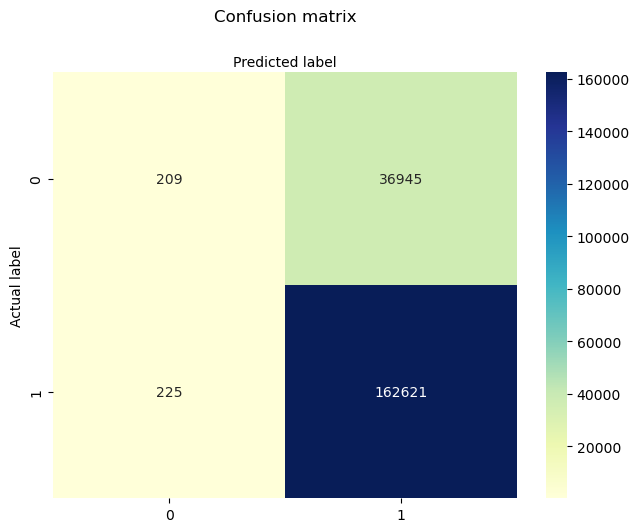

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.show()

In [25]:
from sklearn.metrics import classification_report
target_names = ['member', 'casual']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

      member       0.48      0.01      0.01     37154
      casual       0.81      1.00      0.90    162846

    accuracy                           0.81    200000
   macro avg       0.65      0.50      0.45    200000
weighted avg       0.75      0.81      0.73    200000



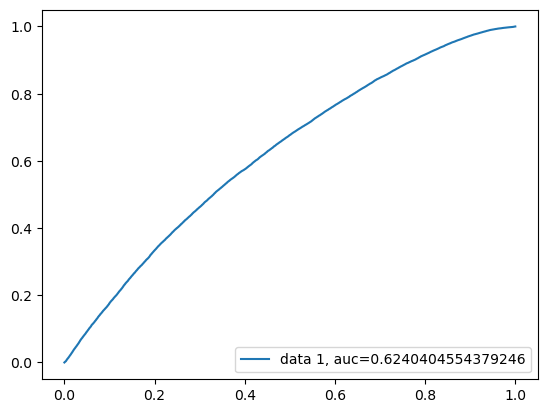

In [27]:
y_pred_proba = logreg.predict_proba(x_test_encoded)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()